In [161]:
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt

def try_float(v):
    try:
        return float(v)
    except ValueError:
        return float("NaN")

def try_int(v):
    try:
        return int(v)
    except ValueError:
        return -1

def gprmc_date(date):
    if date.strip() == "":
        return None
    
    date = int(date)
    
    return pd.Timestamp(
            year=2000+int(date % 100),
            month=int(date//1e2) % 100,
            day=int(date // 1e4),
            tz='UTC'
    )

def gprmc_time(time):
    if time.strip() == "":
        return None

    time = float(time)
    return pd.Timedelta(
        value = int(1000*(time%100)) \
            + 1000*60*(int(time//1e2) % 100) \
            + 1000*3600*int(time//1e4),
        unit = 'millisecond'
    )

def degmin(s):
    try:
        s = float(s)
    except ValueError:
        return float("NaN")
    
    return (s%100)/60 + int(s)//100


def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])


def parse_series(lines, header, fields=[]):
    last_msg = dict()
    series = []
    
    def get_fields(v, r, t):
        try:
            if isinstance(r, int):
                return t(v[r])
            else:
                return np.array(list(map(t, v[r[0]:r[1]])))
        except IndexError:
            return None
        
    
    for l in lines:
        h = l.strip().split(",", 2)[0]
        if h != header:
            last_msg[h] = l
            continue
        v = l.strip().split(",")
        
        series.append([
            get_fields(v, f[1], f[2]) if (isinstance(f[1], int) or isinstance(f[1], tuple)) \
                else get_fields(last_msg.get(f[1], "").split(","), f[2], f[3]) 
            for f in fields
        ])

    return pd.DataFrame(data=series,
                        columns=[f[0] for f in fields])


def read_gnss_lines(lines):
    headers = headers_present(lines)

    gnss_time_msg = '$GPRMC' if '$GPRMC' in headers else '$GNRMC'
    gnss_pos_msg = '$GPGGA' if '$GPGGA' in headers else '$GNGGA'

    t = parse_series(lines, '$TIME', [
        ('Time', 1, try_float),
        ('GNSSTime', gnss_time_msg, 1, gprmc_time),
        ('GNSSDate', gnss_time_msg, 9, gprmc_date)
    ]).dropna()

    if len(t) > 0 and '$TIME' in headers:
        start_ts = t.iloc[0]['GNSSDate'] \
                    + t.iloc[0]['GNSSTime'] \
                    - pd.Timedelta(seconds=t.iloc[0]['Time'])
    else:
        start_ts = None

    nav = parse_series(lines, '$TIME', [
        ('Lat', gnss_pos_msg, 2, degmin),
        ('LatNS', gnss_pos_msg, 3, lambda k: -1 if k == "S" else 1),
        ('Lon', gnss_pos_msg, 4, degmin),
        ('LonEW', gnss_pos_msg, 5, lambda k: -1 if k == "W" else 1),
        ('Alt', gnss_pos_msg, 9, try_float),
        ('Time', 1, try_float),
        ('Speed', gnss_time_msg, 7, try_float)
    ])
    nav = pd.DataFrame({
        'Lat': nav['Lat'] * nav['LatNS'],
        'Lon': nav['Lon'] * nav['LonEW'],
        'Alt': nav['Alt'],
        'Time': nav['Time'],
        'Speed': nav['Speed']*1.852
    }).dropna()

    return (start_ts, nav)


# Přečte DATALOG.txt soubor a vrací list, ve kterém položky odpovídají jednomu běhu.
# Položka je pak tuple složený z
#     (a) první, identifikační řádky běhu a
#     (b) listu s dalšími řádkami běhu.
def read_datalog_lines(filename, greetingstart='$AIRDOS'):
    ret = []
    last_greeting = ""
    lines_accum = []

    with open(filename, 'r') as f:
        for l in f:
            l = l.strip()
            if l == "":
                continue
            if l.startswith(greetingstart):
                if lines_accum:
                    ret.append((last_greeting, lines_accum))
                lines_accum = []
                last_greeting = l
            else:
                lines_accum.append(l)
    
    if lines_accum:
        ret.append((last_greeting, lines_accum))

    return ret

# Vrátí množinu hlaviček, které se vyskytují v předaných řádkách
def headers_present(lines):
    ret = set()
    for l in lines:
        h = l.strip().split(",", 2)[0]
        if not h.startswith('$'):
            sys.stderr.write("Warning: Skipping line: %s\n" % (l.strip()))
            continue
        ret.add(h)
    return ret


In [162]:
def read_divisek_run(greeting, lines):
    start_ts, nav = read_gnss_lines(lines)
    
    headers = headers_present(lines)
    gnss_time_msg = '$GPRMC' if '$GPRMC' in headers else '$GNRMC'
    gnss_pos_msg = '$GPGGA' if '$GPGGA' in headers else '$GNGGA'
    series = parse_series(lines, '$STROKE', [
        ('LocalTime', 2, try_int),
        ('Type', 12, try_int),
        ('GNSSLocalTime', '$TIME', 1, try_float),
        ('GNSSTime', gnss_time_msg, 1, gprmc_time),
        ('GNSSDate', gnss_time_msg, 9, gprmc_date)
    ])
    series.index = pd.to_timedelta(series['LocalTime'], unit='s') \
                    - pd.to_timedelta(series['GNSSLocalTime'], unit='s') \
                    + series['GNSSDate'] + series['GNSSTime']
    return series.filter(['Type'])[pd.notnull(series.index)]

div = pd.concat([
    read_divisek_run(lines, greeting)
    for lines, greeting in read_datalog_lines('data/DATALOG.TXT', greetingstart='$DIVISEK')[4:]
])


In [163]:
import pandas as pd
import numpy as np

blitz = pd.read_csv('data/blitz.txt').filter(['time', 'distance', 'lat', 'lon'])
blitz.index = pd.to_datetime(blitz['time'], utc=True)

magdf = pd.read_csv('data/magnetic_loop.txt', header=None)
mag = pd.to_datetime(magdf[magdf[0] == '$HIT'][4], utc=True).sort_values()
mag = pd.Series(data=np.ones_like(len(mag)), index=mag)

In [18]:
def has_coincidences(of_, in_, dist):
    return list(map(
        lambda t: len(in_[t-dist:t+dist]) > 0,
        of_.index
    ))

def count_coincidences(of_, in_, dist):
    return sum(has_coincidences(of_, in_, dist))

In [77]:
TFROM = pd.Timestamp('2019-08-03 12:49')
TTO = pd.Timestamp('2019-08-03 13:52')
TWINDOW = pd.Timedelta(1.5, unit='s')

detectors = [
    ("MAG", mag),
    ("BLITZ5", blitz[blitz['distance'] <= 5]),
    ("BLITZ10", blitz[blitz['distance'] <= 10]),
    ("BLITZ20", blitz[blitz['distance'] <= 20]),
    ("BLITZ30", blitz[blitz['distance'] <= 30]),
    ("DIVIS48", div[(div['Type'] == 4) | (div['Type'] == 8)]),
    ("DIVIS4", div[div['Type'] == 4]),
    ("DIVIS8", div[div['Type'] == 8])
]

for l, m in detectors:
    m.index = m.index.sort_values()
detectors = [(l, m[TFROM:TTO]) for l, m in detectors]

from IPython.display import HTML, display
import tabulate
table = [ # first row
    [""] + [l_B for l_B, _ in detectors],
] + [ # other rows
    [l_A] + ["%.3f" % (count_coincidences(A, B, TWINDOW)/len(A)) for _, B in detectors]
    for l_A, A in detectors
]   

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,MAG,BLITZ5,BLITZ10,BLITZ20,BLITZ30,DIVIS48,DIVIS4,DIVIS8
MAG,1.000,0.128,0.513,0.513,0.513,0.513,0.487,0.051
BLITZ5,0.684,1.000,1.000,1.000,1.000,0.947,0.895,0.368
BLITZ10,0.628,0.462,1.000,1.000,1.000,0.872,0.846,0.141
BLITZ20,0.505,0.358,0.844,1.000,1.000,0.798,0.734,0.147
BLITZ30,0.455,0.317,0.756,0.894,1.000,0.797,0.732,0.138
DIVIS48,0.312,0.164,0.453,0.492,0.539,1.000,0.875,0.156
DIVIS4,0.345,0.173,0.491,0.527,0.573,1.000,1.000,0.018
DIVIS8,0.111,0.111,0.222,0.278,0.333,1.000,0.111,1.000


In [20]:
def blitz_coincident(with_):
    blitz_ = blitz[TFROM:TTO]
    return blitz_[has_coincidences(blitz_, with_, TWINDOW)]

In [21]:
display(blitz_coincident(div[div['Type'] == 8])['lat'])

time
2019-08-03 12:49:29.132571576+00:00    49.050585
2019-08-03 12:49:29.236467167+00:00    49.044554
2019-08-03 12:49:29.236469723+00:00    49.049402
2019-08-03 13:09:43.158343725+00:00    49.272775
2019-08-03 13:09:43.420716925+00:00    49.174533
2019-08-03 13:09:43.437715179+00:00    49.281359
2019-08-03 13:23:47.453724311+00:00    49.204430
2019-08-03 13:35:38.575953874+00:00    49.178851
2019-08-03 13:49:15.894889357+00:00    49.116847
2019-08-03 13:49:16.087061749+00:00    49.153990
2019-08-03 13:49:16.168665633+00:00    49.123646
Name: lat, dtype: float64

In [22]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
%pylab inline --no-import-all

import pandas as pd


Populating the interactive namespace from numpy and matplotlib


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=432866.72247780627,5436281.383253943,481373.1777313136,5483589.770230824&bboxSR=31284&imageSR=31284&size=800,780&dpi=96&format=png32&transparent=true&f=image


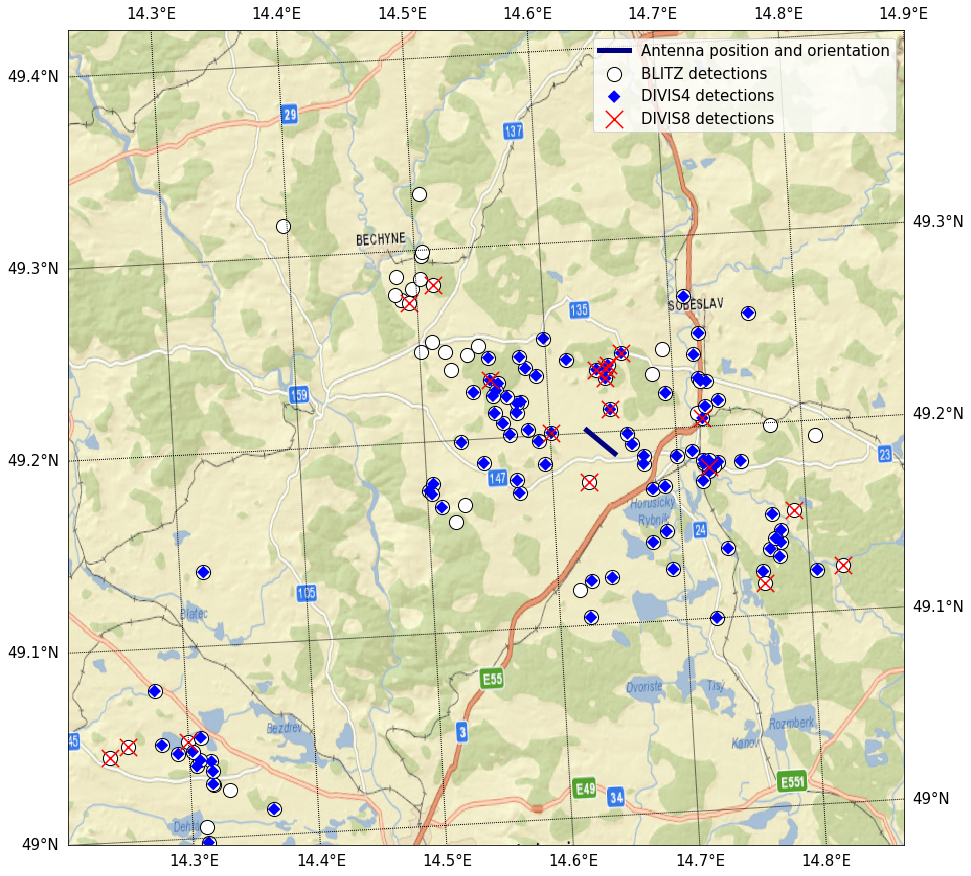

In [78]:
plt.figure(figsize=(15,15))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

df2=blitz[TFROM:TTO]
#df2['lat'] = pd.to_numeric(b['lat'])
#df2['lon'] = pd.to_numeric(df['lon'])
#df2['time'] = pd.to_datetime(df['time'])

m = Basemap(llcrnrlon=14.2,llcrnrlat=49,urcrnrlon=14.9, urcrnrlat=49.4, epsg = 31284)

m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)
#m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 100, verbose= True)

x, y = m(df2.lon.tolist(),df2.lat.tolist())
x4, y4 = m(blitz_coincident(div[div['Type'] == 4])['lon'].tolist(),blitz_coincident(div[div['Type'] == 4])['lat'].tolist())
x8, y8 = m(blitz_coincident(div[div['Type'] == 8])['lon'].tolist(),blitz_coincident(div[div['Type'] == 8])['lat'].tolist())

m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,1])

im1 = m.scatter(x,y,c='white',marker='o', edgecolor='black', s=200, label='BLITZ detections')
#cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
#cb.set_label('[tens of minutes]')

m.scatter(x4,y4,c='blue',marker='D', edgecolor='none', s=80, label='DIVIS4 detections')
m.scatter(x8,y8,c='red',marker='x', edgecolor='none', s=300, label='DIVIS8 detections')

dx, dy = 14.6185489 - 14.639835, 49.2079844 - 49.1949915

x1, y1 = m(14.639835 - dx/2, 49.1949915 - dy/2)
#m.scatter(x1,y1,marker='+', s=300)
x2, y2 = m(14.639835 + dx/2, 49.1949915 + dy/2)
#m.scatter(x,y,marker='+', s=300)
m.plot([x1,x2], [y1,y2], color='navy', lw=5, label='Antenna position and orientation')
plt.legend()

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=432866.72247780627,5436281.383253943,481373.1777313136,5483589.770230824&bboxSR=31284&imageSR=31284&size=800,780&dpi=96&format=png32&transparent=true&f=image


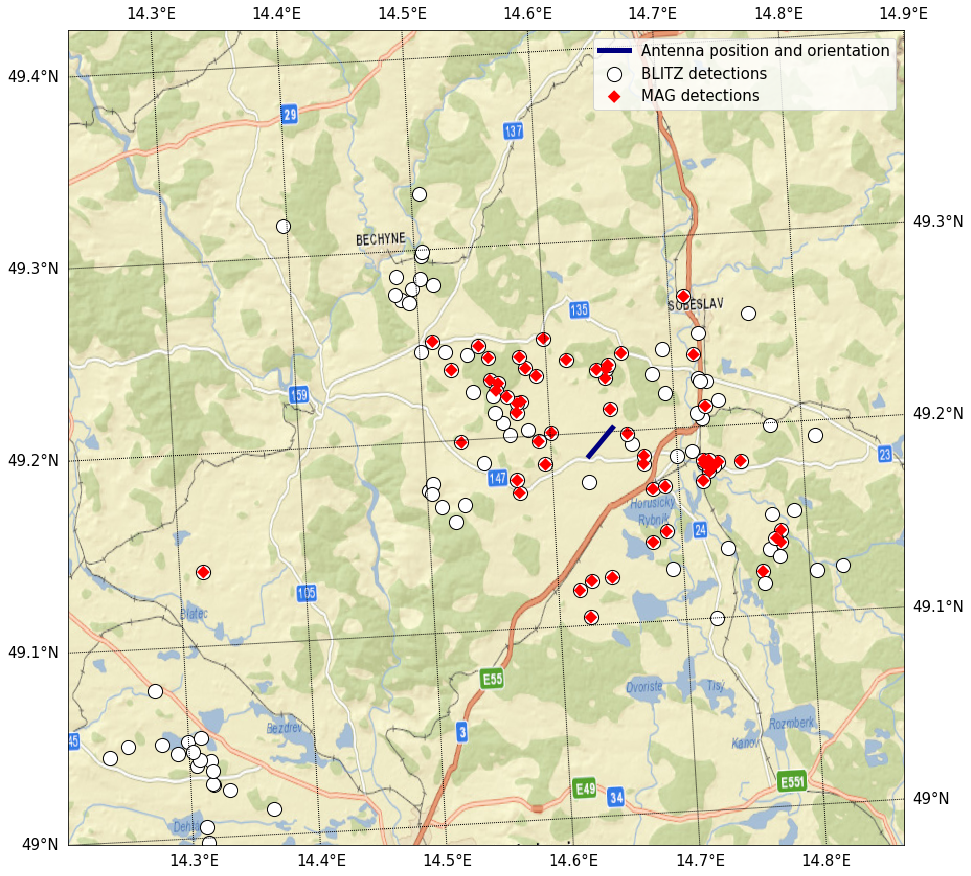

In [24]:
plt.figure(figsize=(15,15))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

df2=blitz[TFROM:TTO]
#df2['lat'] = pd.to_numeric(b['lat'])
#df2['lon'] = pd.to_numeric(df['lon'])
#df2['time'] = pd.to_datetime(df['time'])

m = Basemap(llcrnrlon=14.2,llcrnrlat=49,urcrnrlon=14.9, urcrnrlat=49.4, epsg = 31284)

m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)
#m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 100, verbose= True)

x, y = m(df2.lon.tolist(),df2.lat.tolist())
x4, y4 = m(blitz_coincident(mag)['lon'].tolist(),blitz_coincident(mag)['lat'].tolist())

m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,1])

im1 = m.scatter(x,y,c='white',marker='o', edgecolor='black', s=200, label='BLITZ detections')
#cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
#cb.set_label('[tens of minutes]')

m.scatter(x4,y4,c='red',marker='D', edgecolor='none', s=80, label='MAG detections')

dx, dy = 14.6185489 - 14.639835, 49.2079844 - 49.1949915

x1, y1 = m(14.639835 - dx/2, 49.1949915 - dy/2)
#m.scatter(x1,y1,marker='+', s=300)
x2, y2 = m(14.639835 + dx/2, 49.1949915 + dy/2)

dx_, dy_ = x2 - x1, y2 - y1
x1, y1 = x1 + dx_/2 - dy_/2, y1 + dy_/2 + dx_/2
x2, y2 = x2 - dx_/2 + dy_/2, y2 - dy_/2 - dx_/2

#m.scatter(x,y,marker='+', s=300)
m.plot([x1,x2], [y1,y2], color='navy', lw=5, label='Antenna position and orientation')
plt.legend(loc=1)


In [81]:
from IPython.display import HTML, display
import tabulate
table = [ # first row
    ["", "Count"] + ["<b>%s</b>" % l_B for l_B, _ in detectors],
] + [ # other rows
    ["<b>%s</b>" % l_A, len(A)] + ["%.3f" % (count_coincidences(A, B, TWINDOW)/len(A)) for _, B in detectors]
    for l_A, A in detectors
]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,Count,BLITZ5,BLITZ10,BLITZ20,BLITZ30,DIVIS48,DIVIS4,DIVIS8
BLITZ5,19,1.000,1.000,1.000,1.000,0.947,0.895,0.368
BLITZ10,78,0.462,1.000,1.000,1.000,0.872,0.846,0.141
BLITZ20,109,0.358,0.844,1.000,1.000,0.798,0.734,0.147
BLITZ30,123,0.317,0.756,0.894,1.000,0.797,0.732,0.138
DIVIS48,128,0.164,0.453,0.492,0.539,1.000,0.875,0.156
DIVIS4,110,0.173,0.491,0.527,0.573,1.000,1.000,0.018
DIVIS8,18,0.111,0.222,0.278,0.333,1.000,0.111,1.000


In [26]:
a = np.array([[ # other rows
    [(count_coincidences(A, B, pd.Timedelta(twin, unit='s'))/len(A)) for _, B in detectors]
    for l_A, A in detectors
] for twin in np.arange(1.2, 1.5, 0.1)])

In [27]:
np.max(a, axis=0) - np.min(a, axis=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04587156, 0.04587156, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04065041, 0.04065041, 0.        ],
       [0.        , 0.        , 0.        , 0.0078125 , 0.0078125 ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00909091, 0.00909091,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [80]:
TFROM = pd.Timestamp('2019-08-03 12:49')
TTO = pd.Timestamp('2019-08-03 13:52')
TWINDOW = pd.Timedelta(1.5, unit='s')

detectors = [
    ("BLITZ5", blitz[blitz['distance'] <= 5]),
    ("BLITZ10", blitz[blitz['distance'] <= 10]),
    ("BLITZ20", blitz[blitz['distance'] <= 20]),
    ("BLITZ30", blitz[blitz['distance'] <= 30]),
    ("DIVIS48", div[(div['Type'] == 4) | (div['Type'] == 8)]),
    ("DIVIS4", div[div['Type'] == 4]),
    ("DIVIS8", div[div['Type'] == 8])
]

for l, m in detectors:
    m.index = m.index.sort_values()
detectors = [(l, m[TFROM:TTO]) for l, m in detectors]

from IPython.display import HTML, display
import tabulate
table = [ # first row
    [""] + [l_B for l_B, _ in detectors],
] + [ # other rows
    [l_A] + ["%.3f" % (count_coincidences(A, B, TWINDOW)/len(A)) for _, B in detectors]
    for l_A, A in detectors
]   

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,BLITZ5,BLITZ10,BLITZ20,BLITZ30,DIVIS48,DIVIS4,DIVIS8
BLITZ5,1.000,1.000,1.000,1.000,0.947,0.895,0.368
BLITZ10,0.462,1.000,1.000,1.000,0.872,0.846,0.141
BLITZ20,0.358,0.844,1.000,1.000,0.798,0.734,0.147
BLITZ30,0.317,0.756,0.894,1.000,0.797,0.732,0.138
DIVIS48,0.164,0.453,0.492,0.539,1.000,0.875,0.156
DIVIS4,0.173,0.491,0.527,0.573,1.000,1.000,0.018
DIVIS8,0.111,0.222,0.278,0.333,1.000,0.111,1.000


Text(0, 0.5, 'distance [km]')

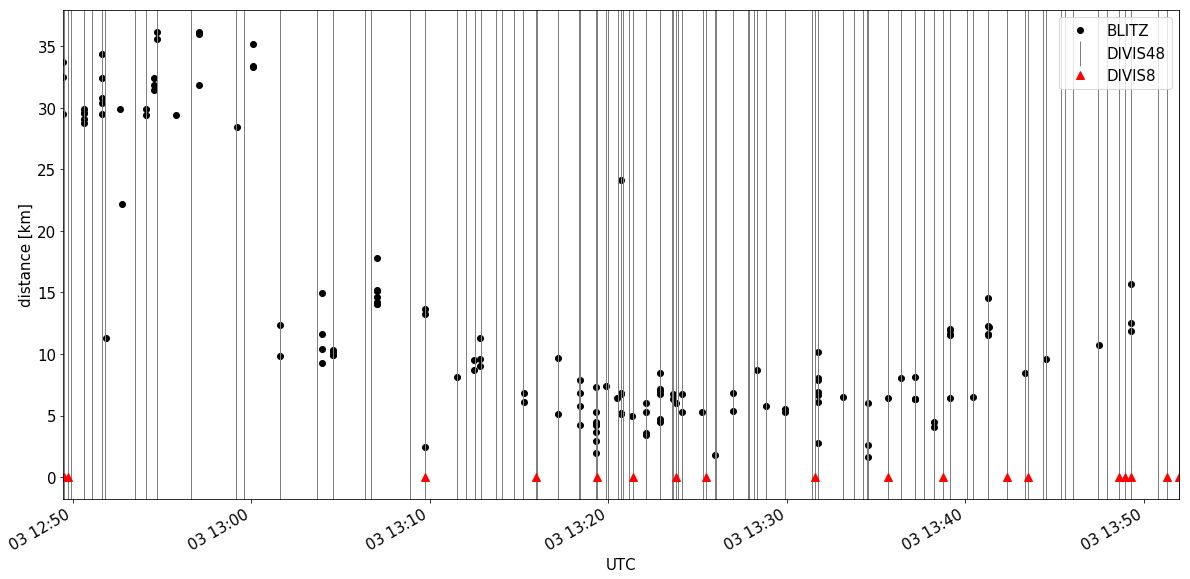

In [160]:
plt.figure(figsize=(20,10))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

df4 = div[div['Type']==4]
df8 = div[div['Type']==8]
df48 = div[div['Type']!=0]

df4 = df4[TFROM:TTO]
df8 = df8[TFROM:TTO]
df48 = df48[TFROM:TTO]
blitz = blitz[TFROM:TTO]

blitz['distance'].plot(marker='o',ls='', color='black',label='BLITZ')
(df48['Type']-4).plot(marker='|',ms=1000,ls='', label='DIVIS48', color='gray')
#(df8['Type']-6).plot(marker='|',ms=1000,ls='', label='DIVIS8', color='gray')
(df8['Type']-8).plot(marker='^',ms=8,ls='', label='DIVIS8', color='red')
#(df4['Type']).plot(marker='|',ms=200,ls='')
#(df8['Type']).plot(marker='|',ms=200,ls='')
lgnd = plt.legend(loc=1)

#change the marker size manually for both lines
lgnd.legendHandles[1]._legmarker.set_markersize(25)
plt.xlabel('UTC')
plt.ylabel('distance [km]')


Text(0, 0.5, 'distance [km]')

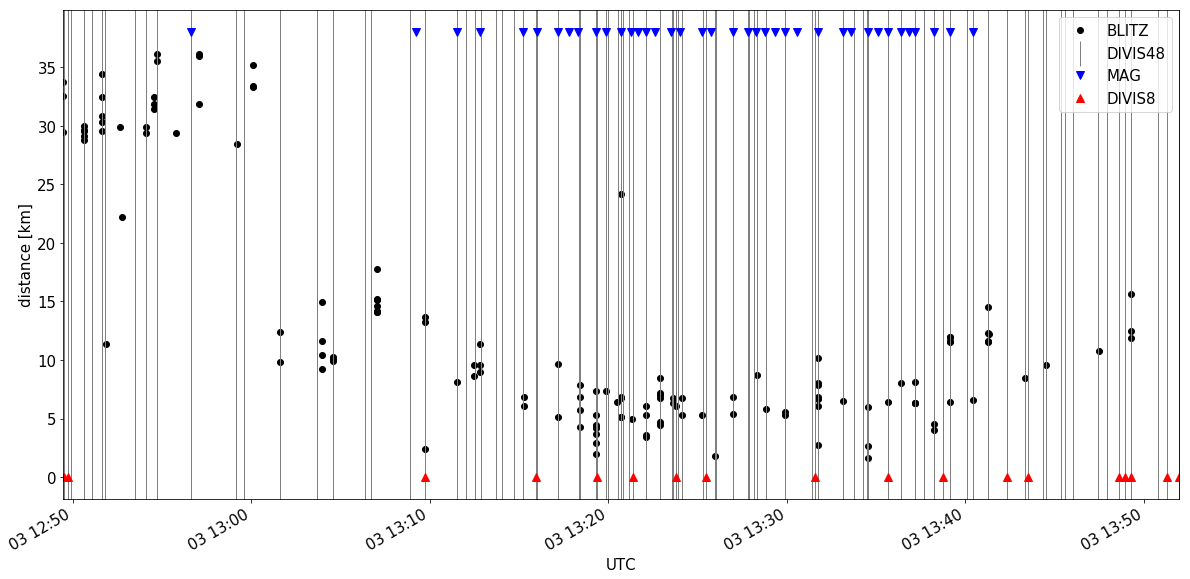

In [180]:
plt.figure(figsize=(20,10))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

df4 = div[div['Type']==4]
df8 = div[div['Type']==8]
df48 = div[div['Type']!=0]

df4 = df4[TFROM:TTO]
df8 = df8[TFROM:TTO]
df48 = df48[TFROM:TTO]
blitz = blitz[TFROM:TTO]
mag = mag[TFROM:TTO]

blitz['distance'].plot(marker='o',ls='', color='black',label='BLITZ')
(df48['Type']-4).plot(marker='|',ms=1000,ls='', label='DIVIS48', color='gray')
(mag+37).plot(marker='v',ms=8,ls='', label='MAG', color='blue')
(df8['Type']-8).plot(marker='^',ms=8,ls='', label='DIVIS8', color='red')
lgnd = plt.legend(loc=1)

#change the marker size manually for both lines
lgnd.legendHandles[1]._legmarker.set_markersize(25)
plt.xlabel('UTC')
plt.ylabel('distance [km]')
